In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of aloocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 need to be the same shape")
    weights = allocator(r1, r2, **kwargs)
    print(weights) ##Uncomment to observe the weights
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights that don't match r1")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [3]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocation between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
    each column is a scenario
    each row is the price for a timestep
    Returns an T x N DataFrame of PSP weights
    """
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)

In [4]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = erk.bond_price(10, 100, 0.05, 12, rates)
price_30 = erk.bond_price(30, 100, 0.05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, 0.05, 12)
rets_10 = erk.bond_total_return(price_10, 100, 0.05, 12)

In [5]:
rets_bonds = bt_mix(rets_10, rets_30, allocator=fixedmix_allocator, w1=.7)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

     0    1    2    3    4    5    6    7    8    9    ...  490  491  492  \
1    0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
2    0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
3    0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
4    0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
5    0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
116  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
117  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
118  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
119  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
120  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   

     493  494  495  496  497  498  499  
1    0.7  0.7  0.7  0.7  0.7  0.7 

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.034984,0.003371,0.544623,4.482377,-0.00146,-0.000906,1.438814,0.0


In [6]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()

rets_zc = zc_prices.pct_change().dropna() #Price returns = total returns due to zero coupon

In [7]:
rets_7030 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030.mean(axis=1) #Mean among the columns for each rows
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

     0    1    2    3    4    5    6    7    8    9    ...  490  491  492  \
1    0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
2    0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
3    0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
4    0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
5    0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
116  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
117  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
118  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
119  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   
120  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  ...  0.7  0.7  0.7   

     493  494  495  496  497  498  499  
1    0.7  0.7  0.7  0.7  0.7  0.7 

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.061924,0.004599,-0.369735,3.270469,-0.002718,-0.001946,6.756712,0.0


## Alternative way (w/ different answers)

- produce summaries for each of the 500 scenarios
- average the stats among those summaries

In [8]:
summaries = erk.summary_stats(rets_7030)

In [9]:
summaries

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.012814,0.113658,0.262619,3.623413,0.049258,0.063742,-0.147300,-0.243291
1,0.049180,0.106523,0.033949,2.596827,0.045846,0.056893,0.175117,-0.176182
2,0.041877,0.098550,-0.114105,2.751640,0.043828,0.057909,0.117174,-0.193689
3,0.006668,0.105041,-0.296189,3.177520,0.051040,0.068736,-0.216310,-0.248956
4,0.060214,0.105977,0.183466,2.687916,0.043350,0.049249,0.277354,-0.297092
...,...,...,...,...,...,...,...,...
495,-0.002567,0.103607,-0.100773,2.591164,0.049853,0.060446,-0.306046,-0.356954
496,0.043689,0.111519,0.576771,3.179229,0.043083,0.051995,0.119336,-0.239959
497,0.052892,0.106202,-0.138886,2.609446,0.046882,0.060131,0.209664,-0.155899
498,0.057400,0.122128,-0.322851,2.616663,0.055892,0.069094,0.218208,-0.226357


In [10]:
summaries.mean()

Annualized Return          0.056602
Annualized Vol             0.106301
Skewness                   0.007452
Kurtosis                   2.958127
Cornish-Fisher VaR (5%)    0.045169
Historic CVaR (5%)         0.057237
Sharpe Ratio               0.245017
Max Drawdown              -0.202561
dtype: float64

In [11]:
def terminal_values(rets):
    """
    returns the final values at the end of the return period for each scenario
    """
    return (rets+1).prod()

In [12]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030, name="70/30")
],axis=1)

,FI,Eq,70/30
mean,1.379558,2.061363,1.830354
std,0.083676,1.126447,0.668001
p_breach,NaN,0.040000,0.010000
e_short,NaN,0.152764,0.105590
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [13]:
import seaborn as sns

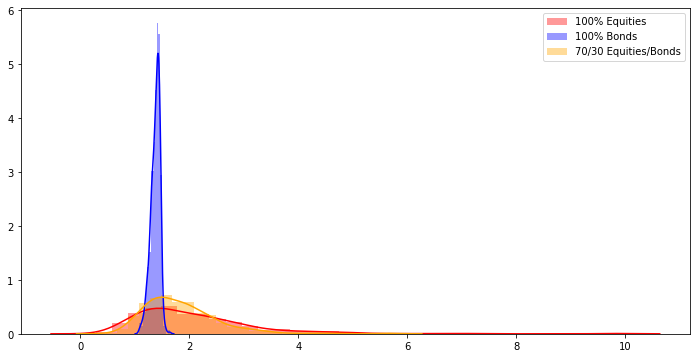

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030), color="orange", label="70/30 Equities/Bonds")
plt.legend()

## Glide Paths for Allocation

In [15]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    """
    Simulates a Target-Date-Fund style gradual move from r1 to r2
    """
    
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col,axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [16]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.80, end_glide=.20)

          0         1         2         3         4         5         6    \
1    0.800000  0.800000  0.800000  0.800000  0.800000  0.800000  0.800000   
2    0.794958  0.794958  0.794958  0.794958  0.794958  0.794958  0.794958   
3    0.789916  0.789916  0.789916  0.789916  0.789916  0.789916  0.789916   
4    0.784874  0.784874  0.784874  0.784874  0.784874  0.784874  0.784874   
5    0.779832  0.779832  0.779832  0.779832  0.779832  0.779832  0.779832   
..        ...       ...       ...       ...       ...       ...       ...   
116  0.220168  0.220168  0.220168  0.220168  0.220168  0.220168  0.220168   
117  0.215126  0.215126  0.215126  0.215126  0.215126  0.215126  0.215126   
118  0.210084  0.210084  0.210084  0.210084  0.210084  0.210084  0.210084   
119  0.205042  0.205042  0.205042  0.205042  0.205042  0.205042  0.205042   
120  0.200000  0.200000  0.200000  0.200000  0.200000  0.200000  0.200000   

          7         8         9    ...       490       491       492  \
1  

In [17]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030, name="70/30"),
    erk.terminal_stats(rets_g8020, name="Glide 80 to 20"),
],axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.379558,2.061363,1.830354,1.686428
std,0.083676,1.126447,0.668001,0.463896
p_breach,NaN,0.040000,0.010000,0.004000
e_short,NaN,0.152764,0.105590,0.087010
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN
